In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pprint
from cohorts.functions import *
import lifelines as ll
import patsy
import functools
import survivalstan
from cohorts.utils import strip_column_names
%matplotlib inline

In [2]:
## set seeds for stan & rngs, to aid in reproducibility
## (note: only reproducible within a machine, not across machines)

seed = 91038753
import random
random.seed(seed)

In [3]:
from utils import data
from utils import paper
from utils.extra_functions import *

# prep data 

## load data

In [4]:
cohort = data.init_cohort(join_with=["ensembl_coverage","tcr_peripheral_a"])

inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
{'dataframe_hash': 7698303973572390439,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [5]:
def tcell_fraction(row):
    return row["T-cell fraction"]

def peripheral_clonality_a(row):
    return row['Clonality']

cols, d = cohort.as_dataframe([snv_count,
                               missense_snv_count,
                               neoantigen_count,
                               expressed_exonic_snv_count,
                               expressed_missense_snv_count,
                               expressed_neoantigen_count,
                               exonic_snv_count,
                               peripheral_clonality_a,
                               tcell_fraction,
                               ],
                              rename_cols=True,
                              return_cols=True)

inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


inner join with ensembl_coverage: 25 to 25 rows


In [6]:
cols

['snv_count',
 'missense_snv_count',
 'neoantigen_count',
 'expressed_exonic_snv_count',
 'expressed_missense_snv_count',
 'expressed_neoantigen_count',
 'exonic_snv_count',
 'peripheral_clonality_a',
 'tcell_fraction']

## construct/rescale variables

In [7]:
## add/modify count variables
d['nonexonic_snv_count'] = d.snv_count - d.exonic_snv_count
cols.append('nonexonic_snv_count')

In [8]:
## create 'observed', log-transformed & centered versions of variables (not normalized by MB)
for col in cols:
    observed_col = 'observed_{}'.format(col)
    log_col = 'log_{}'.format(col)
    log_col_centered = 'log_{}_centered'.format(col)
    log_col_rescaled = 'log_{}_rescaled'.format(col)
    d[observed_col] = d[col]*d['mb']
    d[log_col] = np.log1p(d[observed_col])
    d[log_col_centered] = d[log_col] - np.mean(d[log_col])
    d[log_col_rescaled] = d[log_col_centered]/np.std(d[log_col_centered])

## save key vars in list for future use
vars_centered = ['log_{}_centered'.format(col) for col in cols]
vars_rescaled = ['log_{}_rescaled'.format(col) for col in cols]

In [9]:
## construct new variables for key ratios / comparisons

# what proportion of X are expressed?
d['exonic_expression_ratio'] = d.expressed_exonic_snv_count / d.exonic_snv_count
d['missense_expression_ratio'] = d.expressed_missense_snv_count / d.missense_snv_count
d['neoantigen_expression_ratio'] = d.expressed_neoantigen_count / d.neoantigen_count

# d['expressed_missense2snv_ratio'] = d.expressed_missense_snv_count / d.expressed_snv_count
d['missense2exonic_snv_ratio'] = d.missense_snv_count / d.exonic_snv_count
d['expressed_neoantigen2missense_ratio'] = d.expressed_neoantigen_count / d.expressed_missense_snv_count

extra_cols = ['missense_expression_ratio','neoantigen_expression_ratio', 'exonic_expression_ratio', 'missense2exonic_snv_ratio','expressed_neoantigen2missense_ratio']
## create recentered versions of ratios
for col in extra_cols:
    col_centered = '{}_centered'.format(col)
    col_rescaled = '{}_rescaled'.format(col)
    d[col_centered] = d[col] - np.mean(d[col])
    d[col_rescaled] = d[col_centered]/np.std(d[col_centered])

## append extra-cols to key var lists
vars_centered.extend(['{}_centered'.format(col) for col in extra_cols])
vars_rescaled.extend(['{}_rescaled'.format(col) for col in extra_cols])


## center variables by mean within PD-L1 group

In [10]:
## identify list of variables to center
metrics = list(cols)
metrics.extend(extra_cols)


In [11]:
metrics2 = list(metrics)
metrics2.extend(['pd_l1'])
assert(not 'pd_l1' in metrics)
log_metrics2 = ['log_{}'.format(var) for var in metrics2]
metrics2.extend(log_metrics2)

In [12]:
grp_metrics = [var for var in metrics2 if var in d.columns]

In [13]:
# center variables by group
bygrp = d.loc[:, grp_metrics]
bygrp = bygrp.groupby('pd_l1').transform(lambda x: x - x.mean())
bygrp['patient_id'] = d.patient_id

In [14]:
# merge recentered variables back into original dataframe
df = pd.merge(d, bygrp, on = 'patient_id', suffixes = ['', '_centered_by_pd_l1'])

In [15]:
## prep dflong_pfs which will be used for survival analysis using stan
df_long_pfs = survivalstan.prep_data_long_surv(df = df,
                                               event_col = 'is_progressed_or_deceased',
                                               time_col = 'pfs')
## prep dflong_pfs which will be used for survival analysis using stan
df_long_os = survivalstan.prep_data_long_surv(df = df,
                                               event_col = 'is_deceased',
                                               time_col = 'os')

# multivariate analysis using varying-coef model

In [16]:
models = survivalstan.utils.read_files('../utils/stan')

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

In [17]:
survstan_pfs_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    )
survstan_os_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_os,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    )


In [18]:
survstan_pfs_varcoef2 = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = models['pem_survival_model_unstructured_varcoef_hsprior.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    stan_data = {'nu': 1} 
    )

## multivariate model

In [19]:
formula = 'liver_mets + {}_centered_by_pd_l1 + {}_centered_by_pd_l1 + {}_centered_by_pd_l1'.format(
    'log_missense_snv_count',
     'log_peripheral_clonality_a',
     'log_tcell_fraction',
    )
multivariate_models_varcoef = list()
multivariate_models_varcoef.append(survstan_pfs_varcoef(formula = formula,
                                                        model_cohort = formula,
                                                        group_col='pd_l1'))

NOT reusing model.


Ran in 297.302 sec.


/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


In [20]:
multivariate_models_varcoef_os = list()
multivariate_models_varcoef_os.append(survstan_os_varcoef(formula = formula,
                                                        model_cohort = formula,
                                                        group_col='pd_l1'))

Reusing model.


Ran in 408.986 sec.


### Summarize results from MV model for PFS

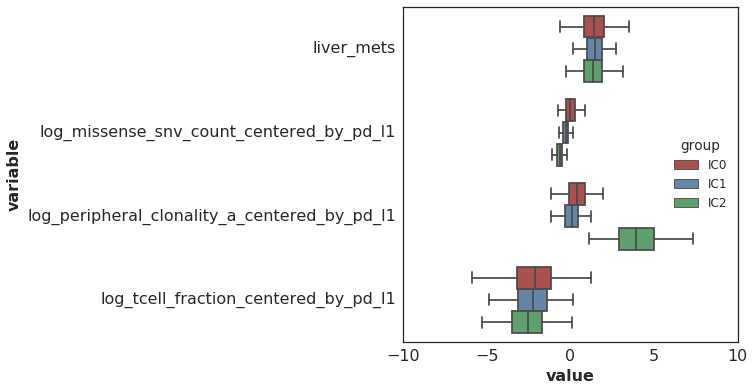

In [21]:
sb.boxplot(data=multivariate_models_varcoef[0]['grp_coefs'],
           x='value',
           y='variable',
           hue='group',
           fliersize=0,
           whis=[2.5, 97.5])
_ = plt.xlim([-10, 10])

{{{mv_model_by_pdl1}}}


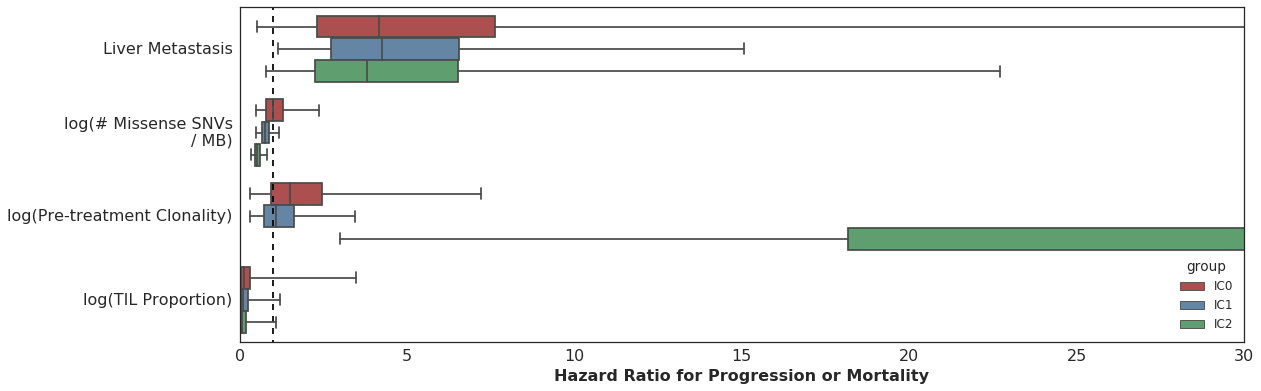

In [22]:
## plot HRs (`exp(beta)`), formatted extra-wide for the manuscript
paper.hyper_figure_label_printer('mv_model_by_pdl1')
## make this plot much wider than usual
current_fig_size = plt.rcParams["figure.figsize"]
new_fig_size = [current_fig_size[0]*3, current_fig_size[1]]
plt.rcParams["figure.figsize"] = new_fig_size
## plot
sb.boxplot(data=multivariate_models_varcoef[0]['grp_coefs'],
           x='exp(beta)',
           y='variable',
           hue='group',
           fliersize=0,
           whis=[2.5, 97.5], 
          )
_ = plt.xlim([0, 30])
_ = plt.vlines(1, -10, 10, linestyles='--')
_ = plt.ylabel('')
#_ = plt.title('Hazard associated with log(Peripheral clonality at timepoint A) \n by level of intratumoral PD-L1 expression')
_ = plt.xlabel('Hazard Ratio for {}'.format(cohort.hazard_plot_name))
_ = plt.yticks([0, 1, 2, 3],
               ['Liver Metastasis',
                'log(# Missense SNVs\n/ MB)',
                'log({tcr_peripheral_a_clonality_short_plot_name})'.format(tcr_peripheral_a_clonality_short_plot_name=cohort.tcr_peripheral_a_clonality_short_plot_name),
                'log({til_fraction_plot_name})'.format(til_fraction_plot_name=cohort.til_fraction_plot_name),
               ])
## revert width to original size
plt.rcParams["figure.figsize"] = current_fig_size


In [23]:
## prep 'beta' coefficients for IC groups
## so that this can be communicated as well
grp_alpha = survivalstan.utils.extract_params_long([multivariate_models_varcoef[0]],
                                                   element='grp_alpha',
                                                   varnames = ['IC0','IC1','IC2'])
ic0_values = grp_alpha.loc[grp_alpha['variable']=='IC0',['iter','value','model_cohort']]
ic0_values.rename(columns={'value': 'ic0_value'}, inplace=True)
grp_alpha = grp_alpha.merge(ic0_values, on=['iter','model_cohort'])
grp_alpha['beta'] = grp_alpha.apply(lambda row: row['value'] - row['ic0_value'], axis=1)
grp_alpha['exp(beta)'] = np.exp(grp_alpha['beta'])
grp_alpha.drop('value', axis=1, inplace=True)
grp_alpha.rename(columns = {'variable': 'group', 'beta': 'value'}, inplace=True)
grp_alpha['variable'] = 'intercept'
grp_alpha.head()

,iter,group,model_cohort,ic0_value,value,exp(beta),variable
0,0,IC0,liver_mets + log_missense_snv_count_centered_b...,-3.714103,0.000000,1.000000,intercept
1,0,IC1,liver_mets + log_missense_snv_count_centered_b...,-3.714103,-2.458640,0.085551,intercept
2,0,IC2,liver_mets + log_missense_snv_count_centered_b...,-3.714103,-2.264194,0.103914,intercept
3,1,IC0,liver_mets + log_missense_snv_count_centered_b...,-4.428929,0.000000,1.000000,intercept
4,1,IC1,liver_mets + log_missense_snv_count_centered_b...,-4.428929,-1.234443,0.290997,intercept


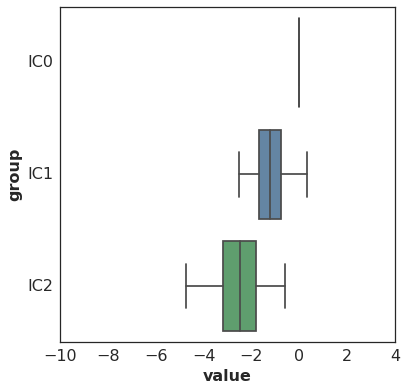

In [24]:
sb.boxplot(data = grp_alpha,
           x = 'value',
           y = 'group',
           fliersize = 0,
           whis = [2.5, 97.5],
          )

           

{{{mv_model_pdl1_coefs}}}


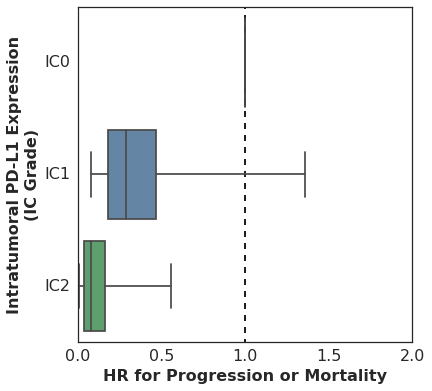

In [25]:
paper.hyper_figure_label_printer('mv_model_pdl1_coefs')
sb.boxplot(data = grp_alpha,
           x = 'exp(beta)',
           y = 'group',
           fliersize = 0,
           whis = [2.5, 97.5],
          )
_ = plt.xlim([0, 2])
_ = plt.vlines(1, -10, 10, linestyles='--')
_ = plt.ylabel('Intratumoral PD-L1 Expression\n(IC Grade)')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))

In [26]:
all_coefs = pd.concat([grp_alpha, multivariate_models_varcoef[0]['grp_coefs']])
all_coefs.head()

,exp(beta),group,ic0_value,iter,model_cohort,value,variable
0,1.000000,IC0,-3.714103,0,liver_mets + log_missense_snv_count_centered_b...,0.000000,intercept
1,0.085551,IC1,-3.714103,0,liver_mets + log_missense_snv_count_centered_b...,-2.458640,intercept
2,0.103914,IC2,-3.714103,0,liver_mets + log_missense_snv_count_centered_b...,-2.264194,intercept
3,1.000000,IC0,-4.428929,1,liver_mets + log_missense_snv_count_centered_b...,0.000000,intercept
4,0.290997,IC1,-4.428929,1,liver_mets + log_missense_snv_count_centered_b...,-1.234443,intercept


{{{mv_model_incl_pdl1_coefs}}}


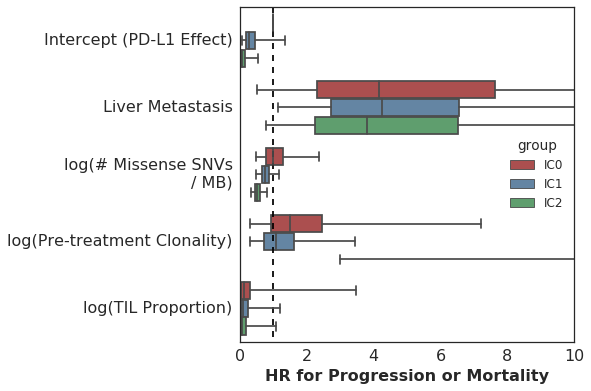

In [27]:
paper.hyper_figure_label_printer('mv_model_incl_pdl1_coefs')
sb.boxplot(data = all_coefs,
           x = 'exp(beta)',
           y = 'variable',
           hue = 'group',
           fliersize = 0,
           whis = [2.5, 97.5],
          )
_ = plt.xlim([0, 10])
_ = plt.ylabel('')
_ = plt.vlines(1, -10, 10, linestyles='--')
_ = plt.yticks([0, 1, 2, 3, 4],
               ['Intercept (PD-L1 Effect)',
                'Liver Metastasis',
                'log(# Missense SNVs\n/ MB)',
                'log({tcr_peripheral_a_clonality_short_plot_name})'.format(tcr_peripheral_a_clonality_short_plot_name=cohort.tcr_peripheral_a_clonality_short_plot_name),
                'log({til_fraction_plot_name})'.format(til_fraction_plot_name=cohort.til_fraction_plot_name),
                ])
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))

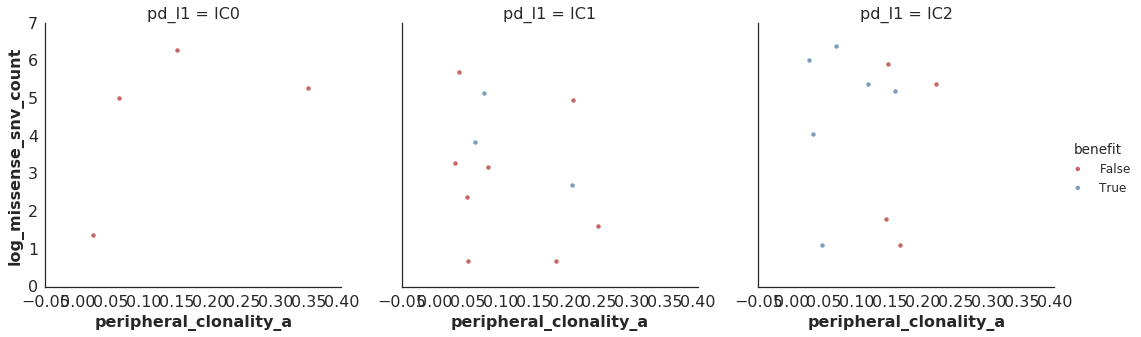

In [28]:
sb.lmplot(data = df, x='peripheral_clonality_a', y='log_missense_snv_count', col='pd_l1',
          hue='benefit', logistic=True, fit_reg=False)

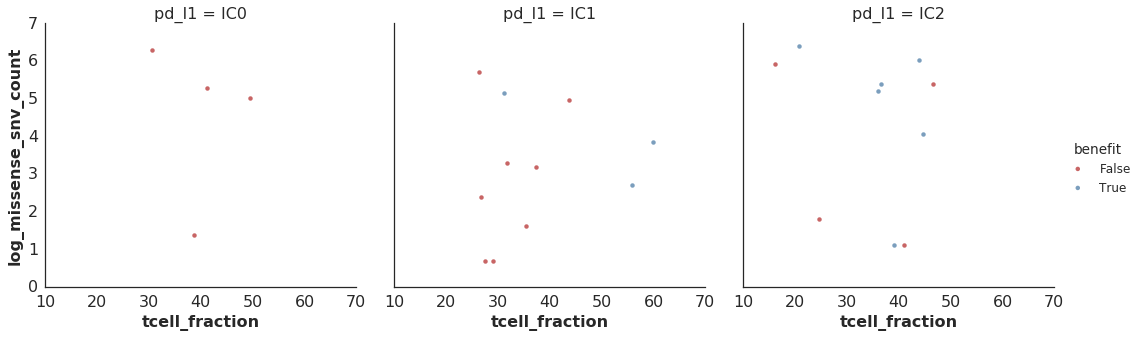

In [29]:
sb.lmplot(data = df, x='tcell_fraction', y='log_missense_snv_count', col='pd_l1',
          hue='benefit', logistic=True, fit_reg=False)

In [30]:
def make_hyper_label(row):
    return 'm0pfs_{}_{}'.format(row['variable'], row['group'])

all_coefs['hyper_label'] = all_coefs.apply(lambda row: make_hyper_label(row), axis=1)

In [31]:
for name, group in all_coefs.groupby('hyper_label'):
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label=name, series=group['exp(beta)'], summary='median')

{{{m0pfs_intercept_IC0:HR=1.00, 95% CI (1.00, 1.00)}}}
{{{m0pfs_intercept_IC1:HR=0.29, 95% CI (0.079, 1.36)}}}
{{{m0pfs_intercept_IC2:HR=0.083, 95% CI (0.0087, 0.55)}}}
{{{m0pfs_liver_mets_IC0:HR=4.17, 95% CI (0.53, 33.98)}}}
{{{m0pfs_liver_mets_IC1:HR=4.27, 95% CI (1.15, 15.08)}}}
{{{m0pfs_liver_mets_IC2:HR=3.80, 95% CI (0.79, 22.70)}}}
{{{m0pfs_log_missense_snv_count_centered_by_pd_l1_IC0:HR=1.00, 95% CI (0.49, 2.37)}}}
{{{m0pfs_log_missense_snv_count_centered_by_pd_l1_IC1:HR=0.76, 95% CI (0.50, 1.16)}}}
{{{m0pfs_log_missense_snv_count_centered_by_pd_l1_IC2:HR=0.53, 95% CI (0.33, 0.83)}}}
{{{m0pfs_log_peripheral_clonality_a_centered_by_pd_l1_IC0:HR=1.51, 95% CI (0.32, 7.22)}}}
{{{m0pfs_log_peripheral_clonality_a_centered_by_pd_l1_IC1:HR=1.09, 95% CI (0.32, 3.46)}}}
{{{m0pfs_log_peripheral_clonality_a_centered_by_pd_l1_IC2:HR=50.87, 95% CI (2.99, 1486.55)}}}
{{{m0pfs_log_tcell_fraction_centered_by_pd_l1_IC0:HR=0.12, 95% CI (0.0028, 3.46)}}}
{{{m0pfs_log_tcell_fraction_centered_by_pd_l

### summarize results from MV model for OS

In [32]:
# summarize coefficients for model with OS as outcome
grp_alpha_os = survivalstan.utils.extract_params_long([multivariate_models_varcoef_os[0]],
                                                   element='grp_alpha',
                                                   varnames = ['IC0','IC1','IC2'])
ic0_values_os = grp_alpha_os.loc[grp_alpha_os['variable']=='IC0',['iter','value','model_cohort']]
ic0_values_os.rename(columns={'value': 'ic0_value'}, inplace=True)
grp_alpha_os = grp_alpha_os.merge(ic0_values_os, on=['iter','model_cohort'])
grp_alpha_os['beta'] = grp_alpha_os.apply(lambda row: row['value'] - row['ic0_value'], axis=1)
grp_alpha_os['exp(beta)'] = np.exp(grp_alpha_os['beta'])
grp_alpha_os.drop('value', axis=1, inplace=True)
grp_alpha_os.rename(columns = {'variable': 'group', 'beta': 'value'}, inplace=True)
grp_alpha_os['variable'] = 'intercept'
all_coefs_os = pd.concat([grp_alpha_os, multivariate_models_varcoef_os[0]['grp_coefs']])
all_coefs_os.head()

,exp(beta),group,ic0_value,iter,model_cohort,value,variable
0,1.000000,IC0,-7.510203,0,liver_mets + log_missense_snv_count_centered_b...,0.000000,intercept
1,0.347772,IC1,-7.510203,0,liver_mets + log_missense_snv_count_centered_b...,-1.056209,intercept
2,0.093100,IC2,-7.510203,0,liver_mets + log_missense_snv_count_centered_b...,-2.374077,intercept
3,1.000000,IC0,-5.899888,1,liver_mets + log_missense_snv_count_centered_b...,0.000000,intercept
4,0.108291,IC1,-5.899888,1,liver_mets + log_missense_snv_count_centered_b...,-2.222937,intercept


{{{mv_model_incl_pdl1_coefs_os}}}


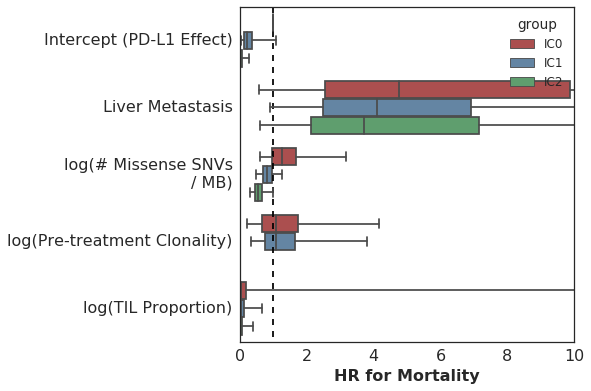

In [33]:
paper.hyper_figure_label_printer('mv_model_incl_pdl1_coefs_os')
sb.boxplot(data = all_coefs_os,
           x = 'exp(beta)',
           y = 'variable',
           hue = 'group',
           fliersize = 0,
           whis = [2.5, 97.5],
          )
_ = plt.xlim([0, 10])
_ = plt.ylabel('')
_ = plt.vlines(1, -10, 10, linestyles='--')
_ = plt.yticks([0, 1, 2, 3, 4],
               ['Intercept (PD-L1 Effect)',
                'Liver Metastasis',
                'log(# Missense SNVs\n/ MB)',
                'log({tcr_peripheral_a_clonality_short_plot_name})'.format(tcr_peripheral_a_clonality_short_plot_name=cohort.tcr_peripheral_a_clonality_short_plot_name),
                'log({til_fraction_plot_name})'.format(til_fraction_plot_name=cohort.til_fraction_plot_name),
                ])
_ = plt.xlabel('HR for {}'.format(cohort.hazard_os_plot_name))

In [34]:
def make_hyper_label(row):
    return 'm0os_{}_{}'.format(row['variable'], row['group'])

all_coefs_os['hyper_label'] = all_coefs_os.apply(lambda row: make_hyper_label(row), axis=1)
for name, group in all_coefs_os.groupby('hyper_label'):
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter, label=name, series=group['exp(beta)'], summary='median')

{{{m0os_intercept_IC0:HR=1.00, 95% CI (1.00, 1.00)}}}
{{{m0os_intercept_IC1:HR=0.23, 95% CI (0.054, 1.10)}}}
{{{m0os_intercept_IC2:HR=0.023, 95% CI (0.00047, 0.30)}}}
{{{m0os_liver_mets_IC0:HR=4.78, 95% CI (0.58, 53.10)}}}
{{{m0os_liver_mets_IC1:HR=4.11, 95% CI (0.91, 16.01)}}}
{{{m0os_liver_mets_IC2:HR=3.73, 95% CI (0.61, 24.52)}}}
{{{m0os_log_missense_snv_count_centered_by_pd_l1_IC0:HR=1.26, 95% CI (0.60, 3.19)}}}
{{{m0os_log_missense_snv_count_centered_by_pd_l1_IC1:HR=0.83, 95% CI (0.50, 1.28)}}}
{{{m0os_log_missense_snv_count_centered_by_pd_l1_IC2:HR=0.56, 95% CI (0.33, 1.00)}}}
{{{m0os_log_peripheral_clonality_a_centered_by_pd_l1_IC0:HR=1.08, 95% CI (0.21, 4.15)}}}
{{{m0os_log_peripheral_clonality_a_centered_by_pd_l1_IC1:HR=1.09, 95% CI (0.33, 3.81)}}}
{{{m0os_log_peripheral_clonality_a_centered_by_pd_l1_IC2:HR=4895.08, 95% CI (80.81, 10374151.41)}}}
{{{m0os_log_tcell_fraction_centered_by_pd_l1_IC0:HR=0.053, 95% CI (0.00053, 11.87)}}}
{{{m0os_log_tcell_fraction_centered_by_pd_l1_I

In [35]:
def print_string(string):
    return "%s" % (string)
paper.hyper_label_printer(formatter=print_string, label='liver_met_plot_name', string='Liver Metastasis')
paper.hyper_label_printer(formatter=print_string, label='missense_snv_count_plot_name', string='# Missense SNVs / MB')
paper.hyper_label_printer(formatter=print_string, label='tcr_peripheral_a_clonality_short_plot_name', string=cohort.tcr_peripheral_a_clonality_short_plot_name)
paper.hyper_label_printer(formatter=print_string, label='til_fraction_plot_name', string=cohort.til_fraction_plot_name)

{{{liver_met_plot_name:Liver Metastasis}}}
{{{missense_snv_count_plot_name:# Missense SNVs / MB}}}
{{{tcr_peripheral_a_clonality_short_plot_name:Pre-treatment Clonality}}}
{{{til_fraction_plot_name:TIL Proportion}}}
